# MODEL FOR CANCER DETECTION

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import warnings

from ydata_profiling import ProfileReport

In [2]:
%matplotlib inline
warnings.filterwarnings('ignore')

----

In [3]:
df = pd.read_csv('The_Cancer_data_1500_V2.csv')
cancer = df.copy()

En este dataset:
1. Age: edad del paciente estudiado.
2. Gender: género del paciente, donde: $0\equiv$ H y $1\equiv$ M.
3. BMI: índice de masa corporal del paciente.
4. Smoking: indica si el paciente es o no fumador, donde: $0\equiv$ no fumador y $1\equiv$ fumador.
5. GeneticRisk: indica el riesgo genético que tiene el paciente para tener cáncer, siendo $0\equiv$ riesgo bajo, $1\equiv$ riesgo medio y $2\equiv$ riesgo alto.
6. PhysicalActivity: número de horas semanales dedicadas por el paciente a hacer deporte.
7. AlcoholIntake: litros semanales de alcohol consumidos por el paciente.
8. CancerHistory: indica si el paciente tiene o no un historial de cáncer, donde $0\equiv$ NO y $1\equiv$ SÍ.
9. Diagnosis: indica si el paciente tiene o no cáncer, con $0\equiv$ NO y $1\equiv$ SÍ.

---

### Análisis previo de los datos

In [4]:
cancer.describe()

Age       Gender          BMI      Smoking  GeneticRisk  \
count  1500.000000  1500.000000  1500.000000  1500.000000  1500.000000   
mean     50.320000     0.490667    27.513321     0.269333     0.508667   
std      17.640968     0.500080     7.230012     0.443761     0.678895   
min      20.000000     0.000000    15.000291     0.000000     0.000000   
25%      35.000000     0.000000    21.483134     0.000000     0.000000   
50%      51.000000     0.000000    27.598494     0.000000     0.000000   
75%      66.000000     1.000000    33.850837     1.000000     1.000000   
max      80.000000     1.000000    39.958688     1.000000     2.000000   

       PhysicalActivity  AlcoholIntake  CancerHistory    Diagnosis  
count       1500.000000    1500.000000    1500.000000  1500.000000  
mean           4.897929       2.417987       0.144000     0.371333  
std            2.866162       1.419318       0.351207     0.483322  
min            0.002410       0.001215       0.000000     0.000000  
25%            2.434609       1.210598       0.000000     0.000000  
50%            4.834316       2.382971       0.000000     0.000000  
75%            7.409896       3.585624       0.000000     1.000000  
max            9.994607       4.987115       1.000000     1.000000

In [5]:
cancer.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
target = 'Diagnosis'
lista = list(cancer.columns)
lista.remove(target)
print(lista)

['Age', 'Gender', 'BMI', 'Smoking', 'GeneticRisk', 'PhysicalActivity', 'AlcoholIntake', 'CancerHistory']


#### Análisis multivariante

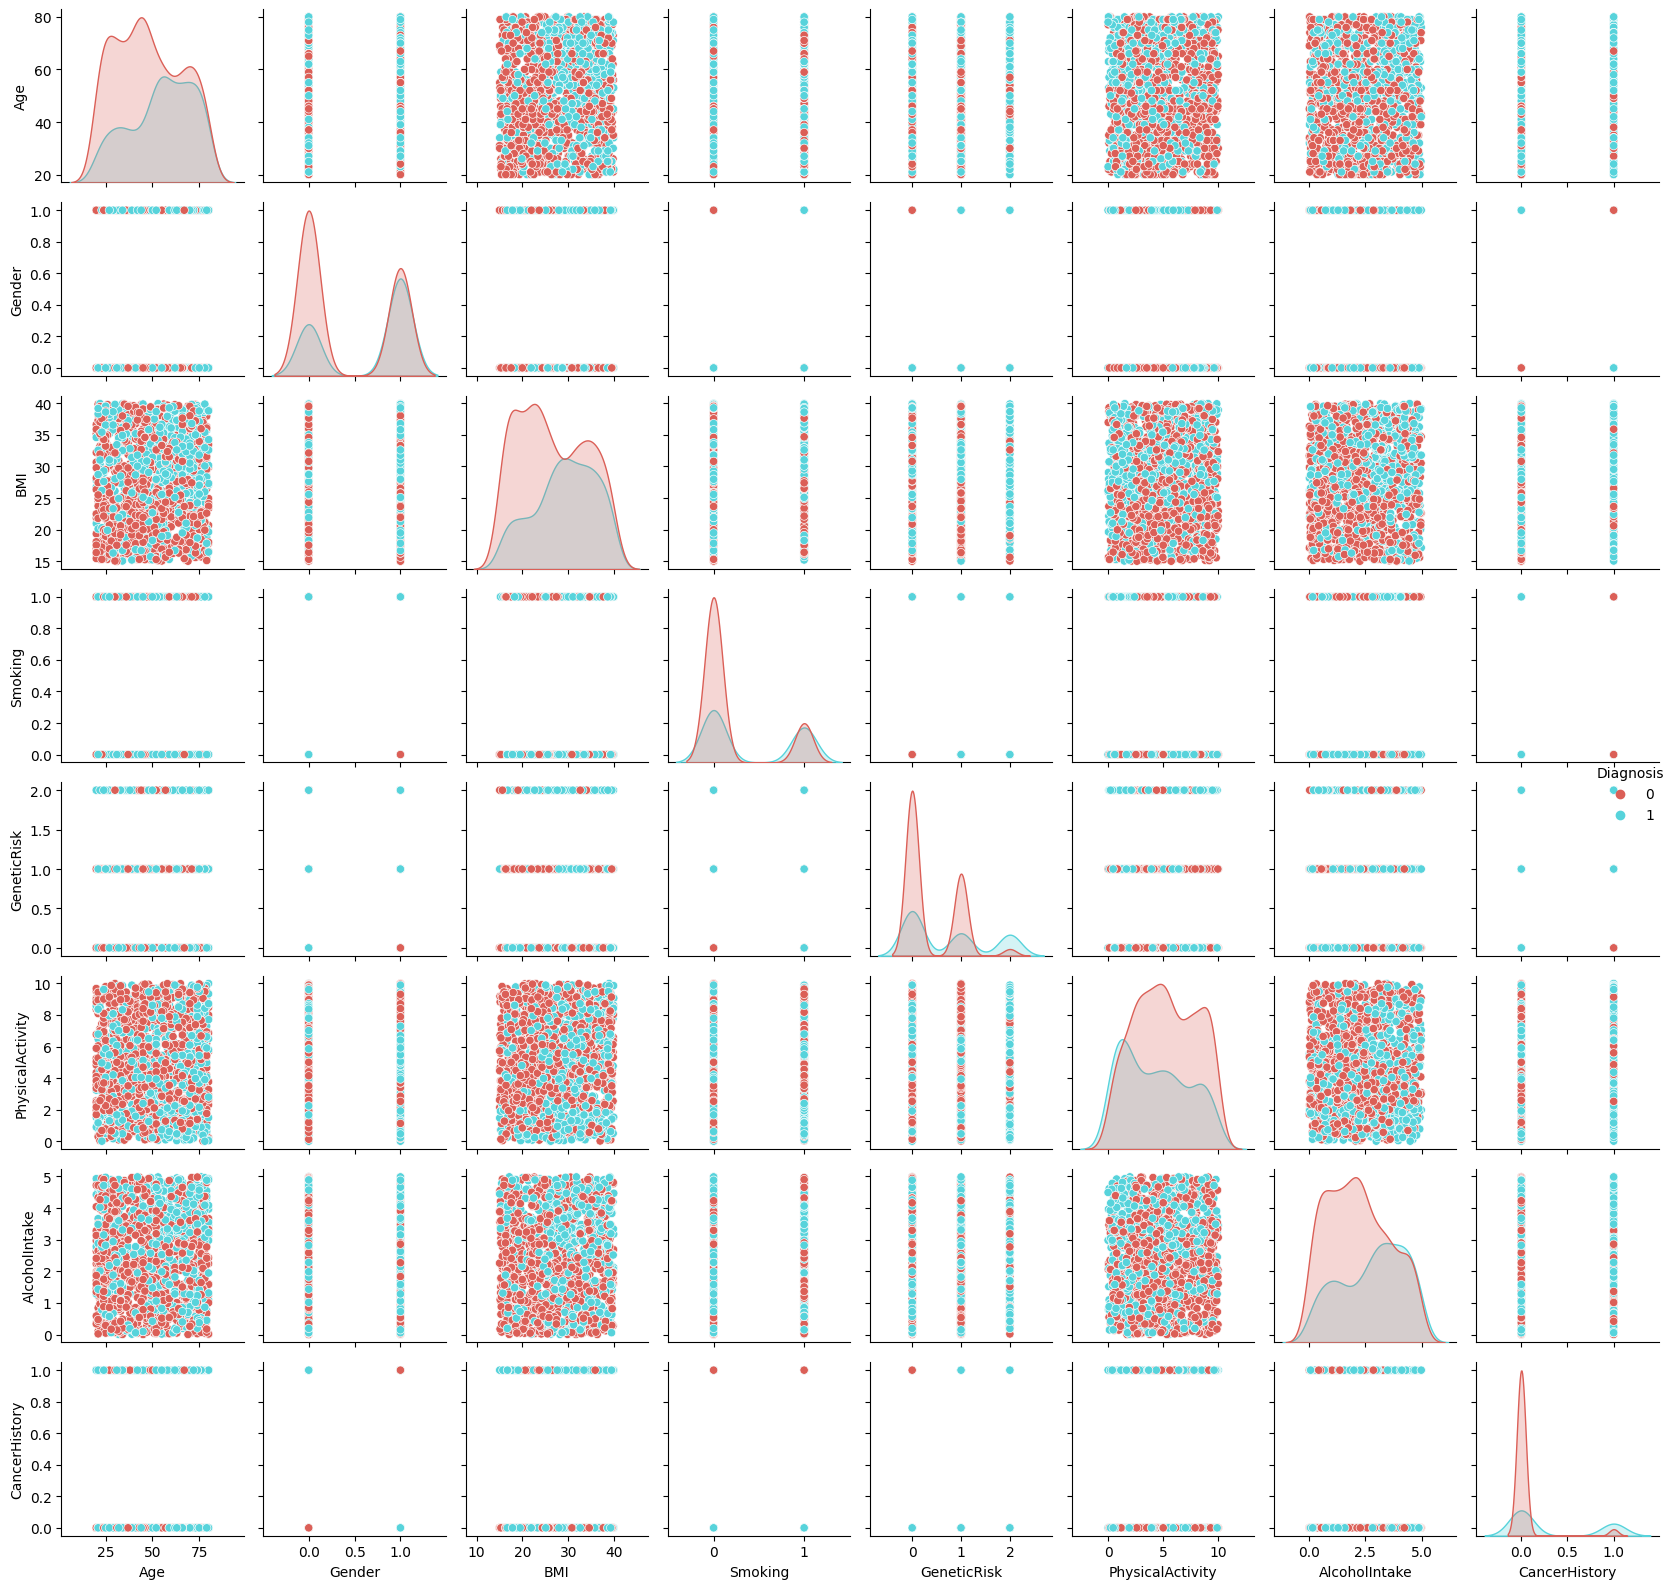

In [7]:
sns.pairplot(cancer,
             vars = ['Age','Gender','BMI','Smoking','GeneticRisk','PhysicalActivity','AlcoholIntake','CancerHistory'],
             size = 2,
             diag_kind = 'kde',
             palette = 'hls',
             hue = 'Diagnosis' )
plt.tight_layout( )
plt.show()

---

### Estudio con Machine Learning

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier,plot_importance
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier

from sklearn.model_selection import train_test_split,GridSearchCV

from sklearn import model_selection,metrics

Separación en conjuntos de entrenamiento y test:

In [9]:
cancer_features = cancer.iloc[:,:-1]
target = cancer[['Diagnosis']]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(cancer_features,
                                                    target,
                                                    test_size = 0.25,
                                                    random_state = 7,
                                                    stratify = target) 

In [11]:
models = []

models.append(('Logistic Regression',
               LogisticRegression(solver = 'liblinear',
                                  random_state = 7,
                                  class_weight = 'balanced')))

models.append(('Random Forest',
               RandomForestClassifier(n_estimators = 250,
                                      random_state = 7)))

models.append(('SVM',
               SVC(gamma = 'auto',
                   random_state = 7)))

models.append(('KNN',
               KNeighborsClassifier()))

models.append(('Decision Tree',
               DecisionTreeClassifier(random_state = 7)))

models.append(('Naive Bayes',
               GaussianNB()))

models.append(('XGBoost',
               XGBClassifier(objective = 'binary:logistic',
                             random_state = 33,
                             n_jobs = -1)))

models.append(('ADA Boost',
               AdaBoostClassifier()))

models.append(('Linear Discrimination',
               LinearDiscriminantAnalysis()))

models.append(('Quadratic Discrimination',
               QuadraticDiscriminantAnalysis()))

models.append(('Gradient Boosting',
              GradientBoostingClassifier()))

In [12]:
acc_results = []
auc_results = []
f1_results = []
recall_results = []
names = []
col = ['Algorithm','ROC AUC Mean','ROC AUC STD','Accuracy Mean','Accuracy STD','F1 Mean','F1 STD','Recall Mean','Recall STD']
df_results = pd.DataFrame(columns = col)
i = 0
for name,model in models:
    kfold = model_selection.KFold(n_splits = 10,
                                  random_state = None) 

    cv_acc_results = model_selection.cross_val_score(model,
                                                     X_train,y_train,
                                                     cv = kfold, 
                                                     scoring = 'accuracy')
    cv_auc_results = model_selection.cross_val_score(model,
                                                     X_train,y_train,
                                                     cv = kfold,
                                                     scoring = 'roc_auc')
    cv_f1_results = model_selection.cross_val_score(model,
                                                    X_train,y_train,
                                                    cv = kfold,
                                                    scoring = 'f1')
    cv_recall_results = model_selection.cross_val_score(model,
                                                        X_train,y_train,
                                                        cv = kfold,
                                                        scoring = 'recall')
    acc_results.append(cv_acc_results)
    auc_results.append(cv_auc_results)
    f1_results.append(cv_f1_results)
    recall_results.append(cv_recall_results)
    names.append(name)
    
    df_results.loc[i] = [name,
                         round(cv_auc_results.mean()*100,2),
                         round(cv_auc_results.std()*100,2),
                         round(cv_acc_results.mean()*100,2),
                         round(cv_acc_results.std()*100,2),
                         round(cv_f1_results.mean()*100,2),
                         round(cv_f1_results.std()*100,2),
                         round(cv_recall_results.mean()*100,2),
                         round(cv_recall_results.std()*100,2)]
    i += 1
df_results.sort_values(by = ['ROC AUC Mean'],
                       ascending = False)

Algorithm  ROC AUC Mean  ROC AUC STD  Accuracy Mean  \
6                    XGBoost         95.53         1.73          91.11   
7                  ADA Boost         95.51         1.33          92.26   
10         Gradient Boosting         95.49         1.55          92.71   
1              Random Forest         95.20         2.12          91.37   
8      Linear Discrimination         91.97         1.92          84.53   
0        Logistic Regression         91.92         1.78          84.36   
9   Quadratic Discrimination         91.30         2.41          84.62   
5                Naive Bayes         91.20         2.75          82.67   
4              Decision Tree         83.81         2.73          85.06   
2                        SVM         73.08         3.30          69.05   
3                        KNN         68.52         4.10          67.81   

    Accuracy STD  F1 Mean  F1 STD  Recall Mean  Recall STD  
6           2.31    87.69    2.66        84.93        5.02  
7           1.50    89.23    2.47        87.37        3.93  
10          1.83    90.05    1.78        88.02        3.25  
1           1.96    87.79    2.50        83.58        5.35  
8           3.25    77.87    4.98        73.84        5.51  
0           3.25    79.92    4.26        84.12        3.97  
9           2.81    77.18    5.28        71.06        6.66  
5           2.91    72.31    6.10        62.00        6.69  
4           2.89    79.64    3.62        78.76        2.91  
2           6.00    47.34    7.52        37.76        8.20  
3           5.04    49.62    5.08        42.84        6.40

Los modelos con mejor precisión son los siguientes:
1. XGBoost
2. ADABoost
3. Gradient Boosting
4. Random Forest

Todos estos modelos tienen un valor de ROC AUC mayor que 95 y un valor de precisión superior a 90. En las demás métricas utilizadas también tienen índices muy buenos.

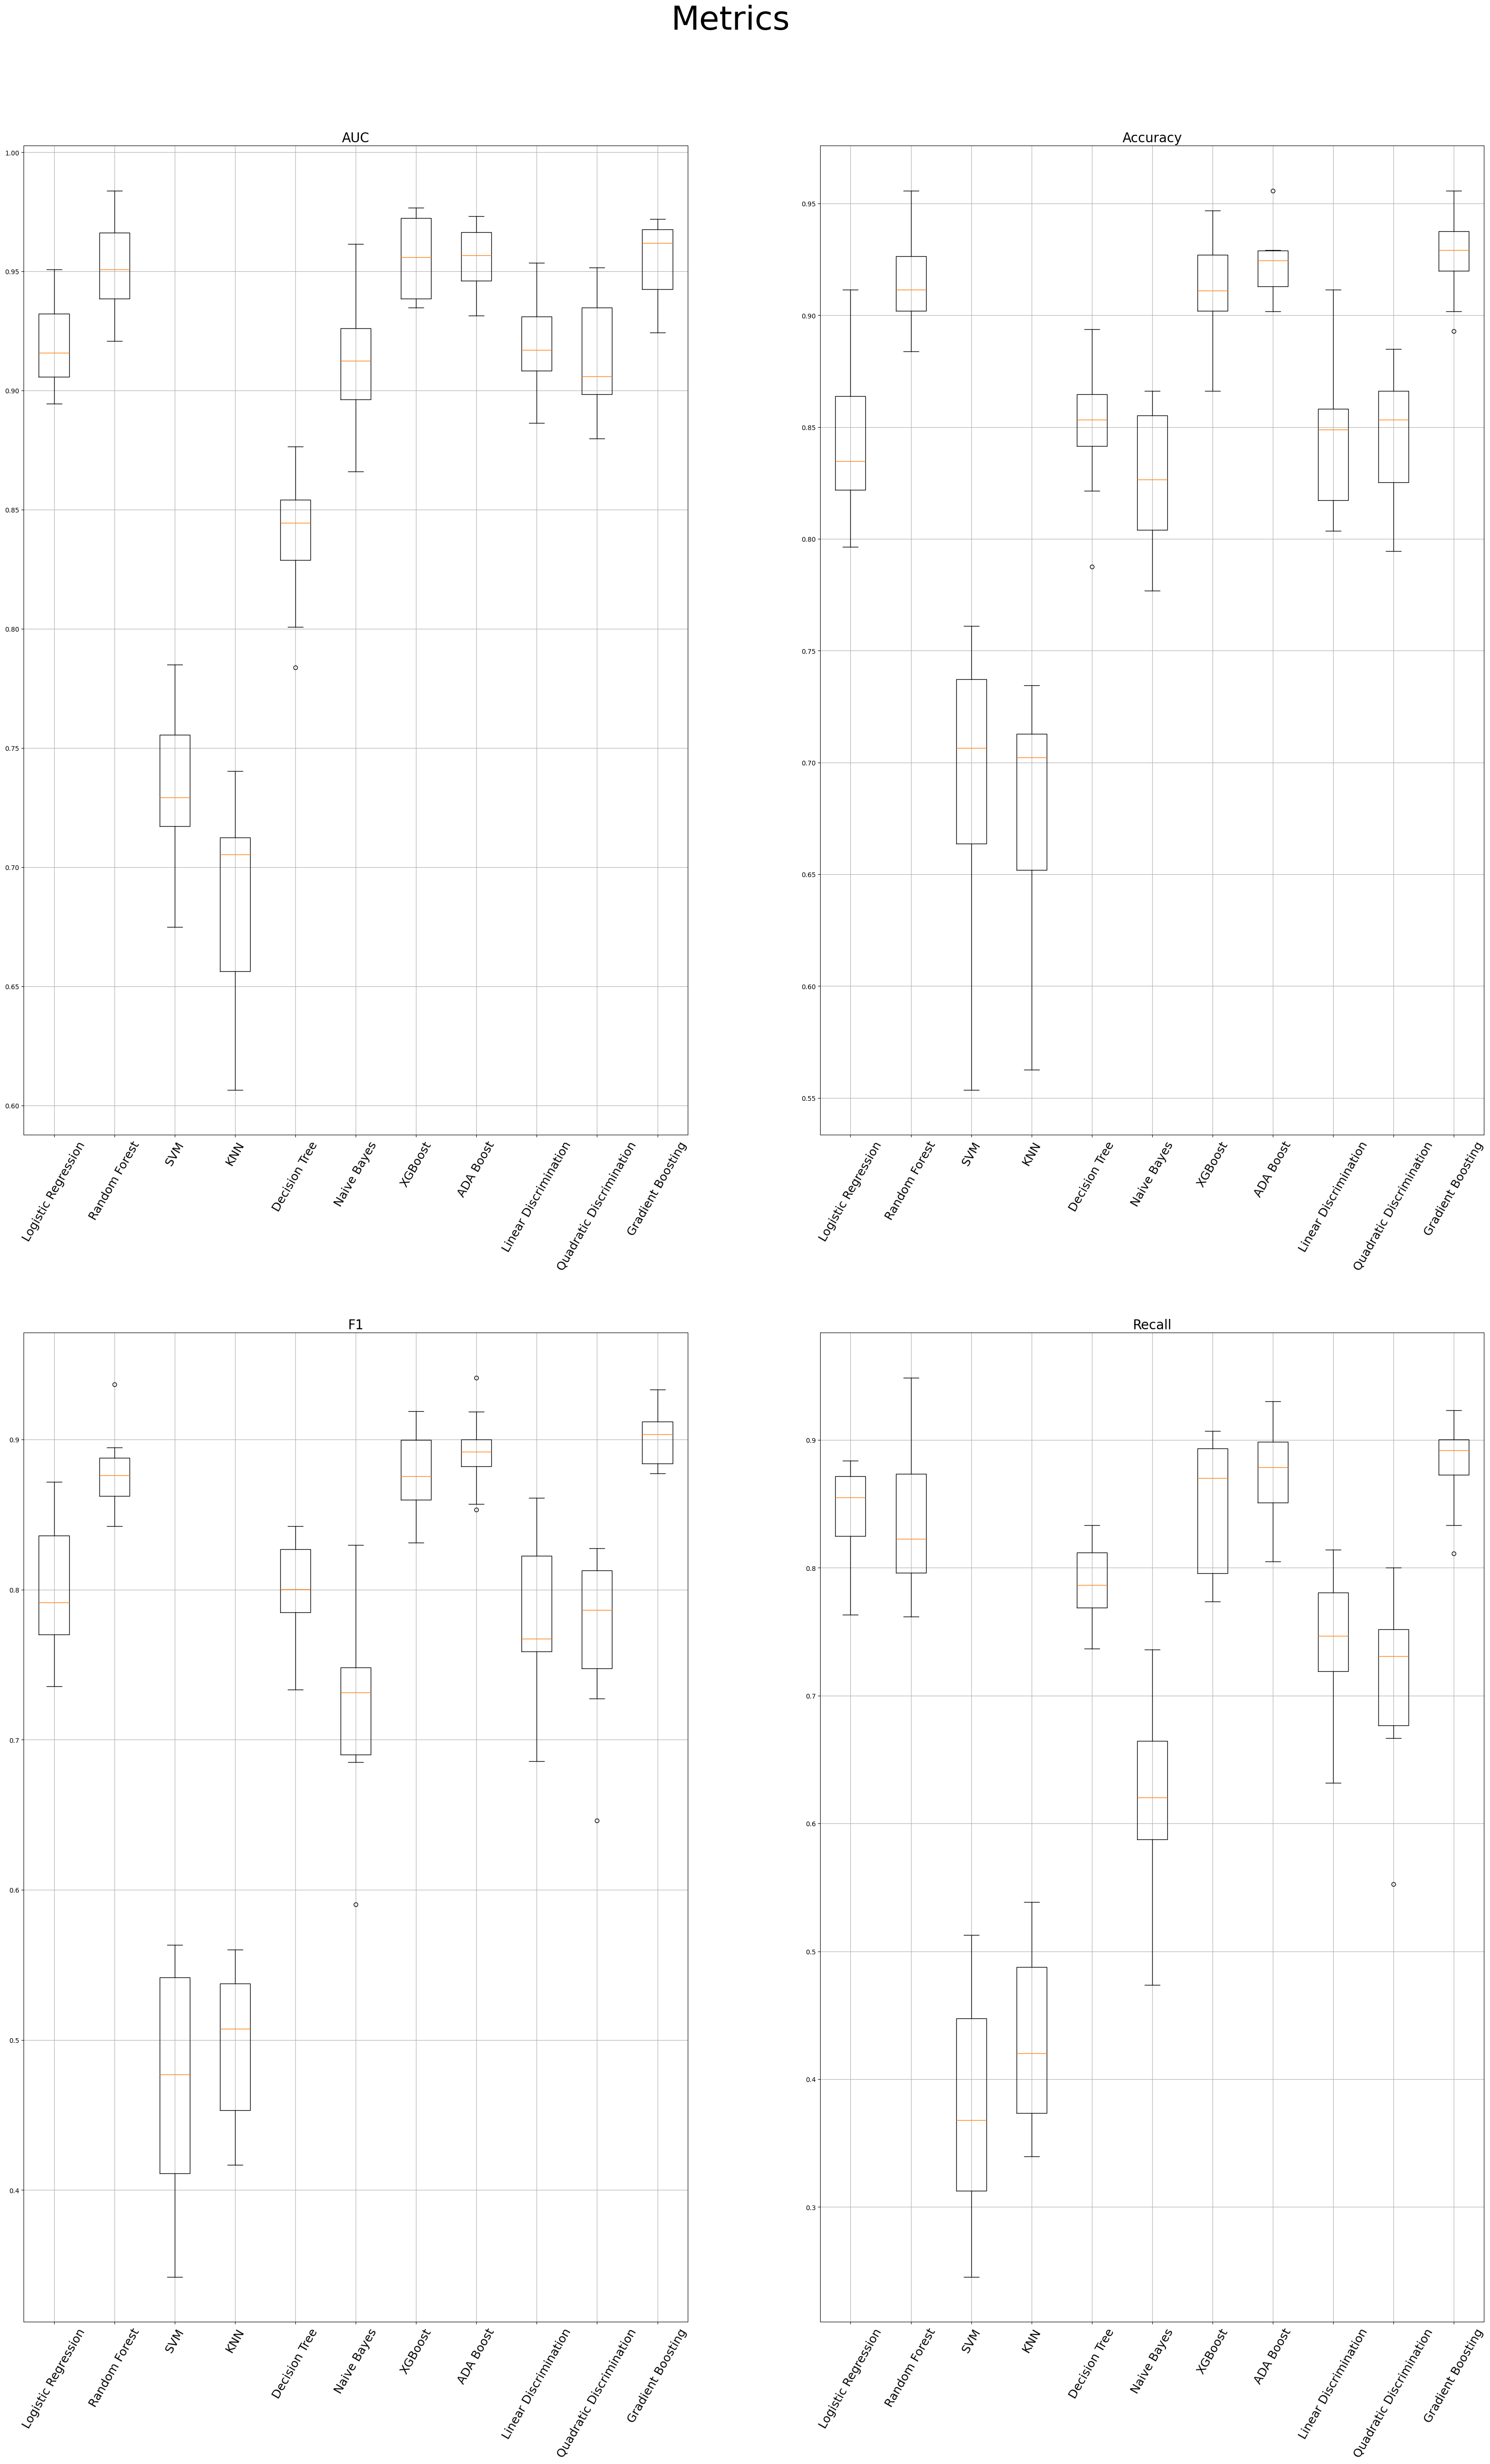

In [13]:
fig = plt.figure(figsize = (40,60))
fig.suptitle('Metrics',y = 0.93,fontsize = 50)
ax = fig.add_subplot(221)
plt.grid()
plt.boxplot(auc_results)
ax.set_xticklabels(names,rotation = 60,fontsize = 18)
plt.title('AUC',fontsize = 20)

ax = fig.add_subplot(222)
plt.grid()
plt.boxplot(acc_results)
ax.set_xticklabels(names,rotation = 60,fontsize = 18)
plt.title('Accuracy',fontsize = 20)

ax = fig.add_subplot(223)
plt.grid()
plt.boxplot(f1_results)
ax.set_xticklabels(names,rotation = 60,fontsize = 18)
plt.title('F1',fontsize = 20)

ax = fig.add_subplot(224)
plt.grid()
plt.boxplot(recall_results)
ax.set_xticklabels(names,rotation = 60,fontsize = 18)
plt.title('Recall',fontsize = 20)

plt.show()
fig.savefig('metrics.png',bbox_inches='tight')

---

---

### XGBoost Model

In [14]:
xgb = XGBClassifier(objective = 'binary:logistic',
                    random_state = 33,
                    n_jobs = -1)
param_grid = {'eta': [0.01,0.05,0.10,0.15,0.20],
              'subsample': [0.5,0.6,0.7],
              'colsample_bytree': [0.5,0.6,0.7],
              'n_estimators': [50,100,150,200]}

grid_obj = GridSearchCV(xgb,
                        return_train_score = True,
                        param_grid = param_grid,
                        scoring = 'roc_auc',
                        cv = 5,
                        n_jobs = 12)
grid_fit = grid_obj.fit(X_train,y_train)
rf_opt = grid_fit.best_estimator_

print('-'*20)
print("best params: "+str(grid_obj.best_estimator_))
print("best params: "+str(grid_obj.best_params_))
print('best score:',grid_obj.best_score_)
print('='*20)

--------------------
best params: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.05, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=150,
              n_jobs=-1, num_parallel_tree=None, ...)
best params: {'colsample_bytree': 0.7, 'eta': 0.05, 'n_estimators': 150, 'subsample': 0.5}
best score: 0.9551241626179076


In [15]:
grid_fit = grid_obj.fit(X_train,y_train)
xgb_opt = grid_fit.best_estimator_

print('-'*20)
print("Best params: "+str(grid_obj.best_estimator_))
print("Best params: "+str(grid_obj.best_params_))
print('Best score:',grid_obj.best_score_)
print('='*20)

--------------------
Best params: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.05, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=150,
              n_jobs=-1, num_parallel_tree=None, ...)
Best params: {'colsample_bytree': 0.7, 'eta': 0.05, 'n_estimators': 150, 'subsample': 0.5}
Best score: 0.9551241626179076


In [16]:
cnf_matrix_xgb = metrics.confusion_matrix(y_test,xgb_opt.predict(X_test))
importances_xgb = xgb_opt.feature_importances_
indices_xgb = np.argsort(importances_xgb)[::-1]
names_xgb = [X_train.columns[i] for i in indices_xgb] 

---

### AdaBoost Model

In [17]:
ada_classifier = AdaBoostClassifier()
param_grid = {'n_estimators': [50,100,150,200,250],
              'learning_rate': [1,5,10,15,20]}

grid_obj = GridSearchCV(ada_classifier,
                        return_train_score = True,
                        param_grid = param_grid,
                        scoring = 'roc_auc',
                        cv = 10,
                        n_jobs = 12)

grid_fit = grid_obj.fit(X_train,y_train)
ada_opt = grid_fit.best_estimator_

print('='*50)
print("Best params: "+str(grid_obj.best_estimator_))
print("Best params: "+str(grid_obj.best_params_))
print('Best score:',grid_obj.best_score_)
print('='*50)

Best params: AdaBoostClassifier(learning_rate=1)
Best params: {'learning_rate': 1, 'n_estimators': 50}
Best score: 0.955843428749033


In [18]:
cnf_matrix_ada = metrics.confusion_matrix(y_test,ada_opt.predict(X_test))
importances_ada = ada_opt.feature_importances_
indices_ada = np.argsort(importances_ada)[::-1]
names_ada = [X_train.columns[i] for i in indices_ada] 

---

### Gradient Boosting Model

In [19]:
gb_classifier = GradientBoostingClassifier()
param_grid = {'min_samples_split': [1,3,5],
              'min_samples_leaf': [3,5,7],
              'max_depth': [3,5,7],
              'learning_rate': [0.25,0.3,0.35],
              'n_estimators': [30,50,60]}

grid_obj = GridSearchCV(gb_classifier,
                        return_train_score = True,
                        param_grid = param_grid,
                        scoring = 'roc_auc',
                        cv = 10,
                        n_jobs = 12)

grid_fit = grid_obj.fit(X_train,y_train)
gb_opt = grid_fit.best_estimator_

print('='*50)
print("Best params: "+str(grid_obj.best_estimator_))
print("Best params: "+str(grid_obj.best_params_))
print('Best score:',grid_obj.best_score_)
print('='*50)

Best params: GradientBoostingClassifier(learning_rate=0.3, min_samples_leaf=5,
                           min_samples_split=5, n_estimators=60)
Best params: {'learning_rate': 0.3, 'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 60}
Best score: 0.9591062986513739


In [20]:
cnf_matrix_gb = metrics.confusion_matrix(y_test,gb_opt.predict(X_test))
importances_gb = gb_opt.feature_importances_
indices_gb = np.argsort(importances_gb)[::-1]
names_gb = [X_train.columns[i] for i in indices_gb] 

---

### Random Forest Model

Este modelo obtiene muy buenos resultados en todas las métricas y además permite hacer un análisis de interpretabilidad:

In [21]:
rf_classifier = RandomForestClassifier(class_weight = "balanced",
                                       random_state = None)
param_grid = {'n_estimators': [100,110,120],
              'min_samples_split':[7,8,9],
              'min_samples_leaf': [2,3,4],
              'max_depth': [13,14,15]}

grid_obj = GridSearchCV(rf_classifier,
                        return_train_score = True,
                        param_grid = param_grid,
                        scoring = 'roc_auc',
                        cv = 10,
                        n_jobs = 12)

grid_fit = grid_obj.fit(X_train,y_train)
rf_opt = grid_fit.best_estimator_

print('-'*20)
print("best params: "+str(grid_obj.best_estimator_))
print("best params: "+str(grid_obj.best_params_))
print('best score:',grid_obj.best_score_)
print('='*20)

--------------------
best params: RandomForestClassifier(class_weight='balanced', max_depth=14,
                       min_samples_leaf=4, min_samples_split=8)
best params: {'max_depth': 14, 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 100}
best score: 0.9542459752709054


In [22]:
cnf_matrix_rf = metrics.confusion_matrix(y_test,rf_opt.predict(X_test))
importances_rf = rf_opt.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]
names_rf = [X_train.columns[i] for i in indices_rf] 

---

## Models comparison

#### Confusion matrixes

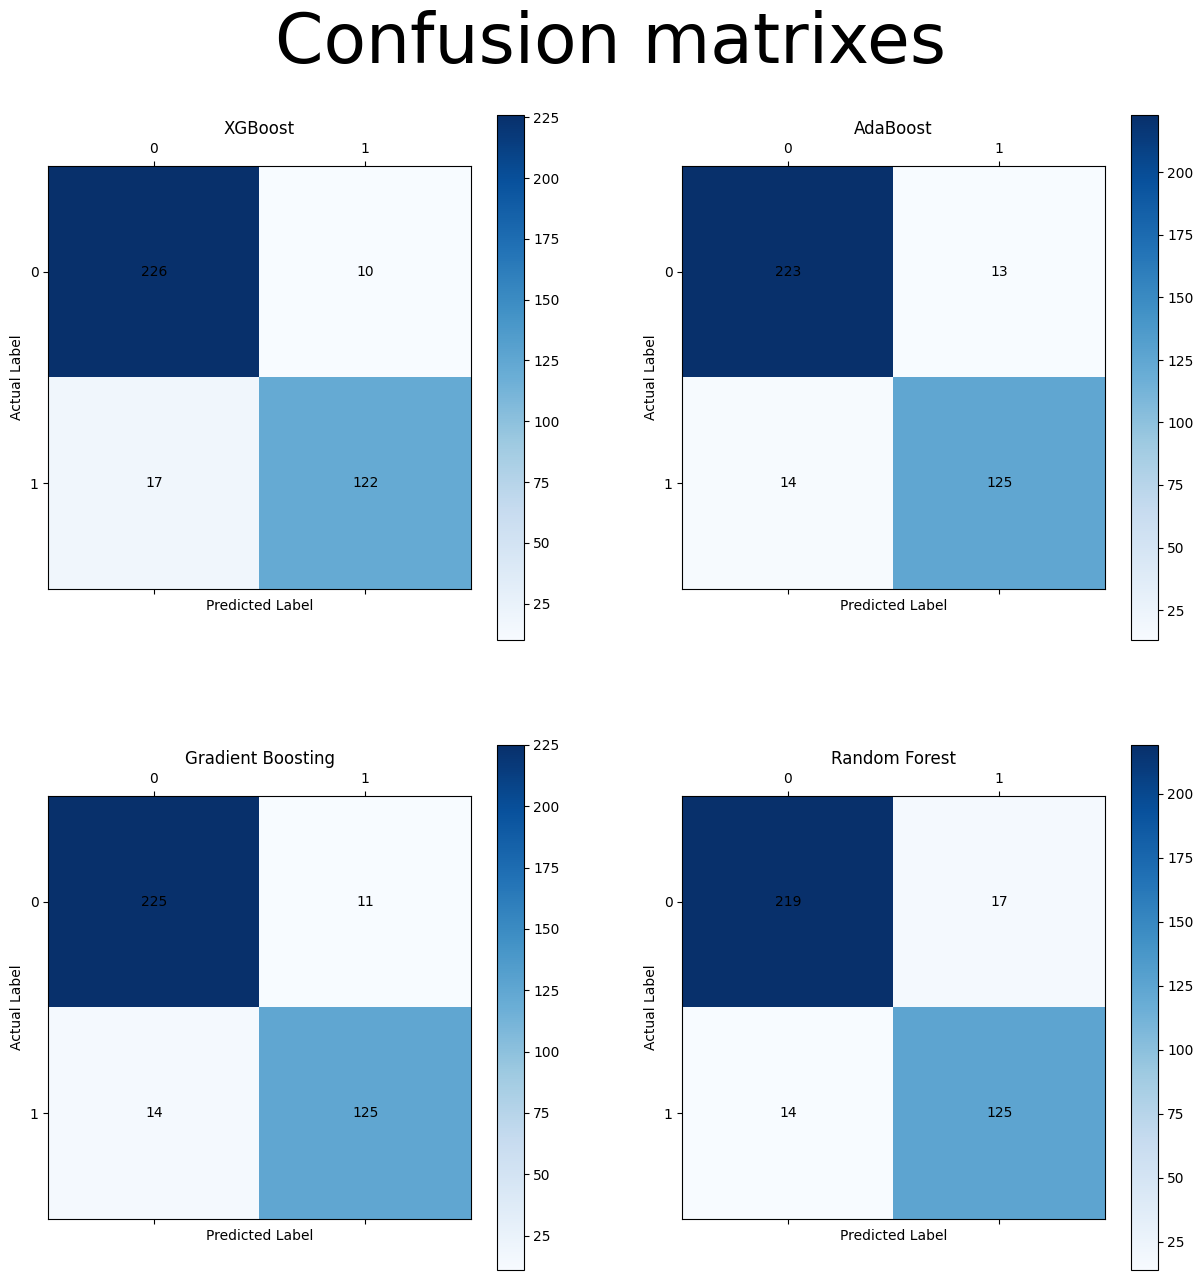

In [23]:
class_names = [0,1]
fig = plt.figure(figsize = (15,15))
fig.suptitle('Confusion matrixes',fontsize = 50,y = 0.95)

ax = fig.add_subplot(221)
cax = ax.matshow(cnf_matrix_xgb,
                 cmap = plt.cm.Blues)
plt.colorbar(cax)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks,class_names)
plt.yticks(tick_marks,class_names)
for i in range(cnf_matrix_xgb.shape[0]):
    for j in range(cnf_matrix_xgb.shape[1]):
        ax.text(x = j,
                y = i,
                s = cnf_matrix_xgb[i,j],
                va = 'center',
                ha = 'center')
plt.title('XGBoost')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

ax = fig.add_subplot(222)
cax = ax.matshow(cnf_matrix_ada,
                 cmap = plt.cm.Blues)
plt.colorbar(cax)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks,class_names)
plt.yticks(tick_marks,class_names)
for i in range(cnf_matrix_ada.shape[0]):
    for j in range(cnf_matrix_ada.shape[1]):
        ax.text(x = j,
                y = i,
                s = cnf_matrix_ada[i,j],
                va = 'center',
                ha = 'center')
plt.title('AdaBoost')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

ax = fig.add_subplot(223)
cax = ax.matshow(cnf_matrix_gb,
                 cmap = plt.cm.Blues)
plt.colorbar(cax)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks,class_names)
plt.yticks(tick_marks,class_names)
for i in range(cnf_matrix_gb.shape[0]):
    for j in range(cnf_matrix_gb.shape[1]):
        ax.text(x = j,
                y = i,
                s = cnf_matrix_gb[i,j],
                va = 'center',
                ha = 'center')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Gradient Boosting')

ax = fig.add_subplot(224)
cax = ax.matshow(cnf_matrix_rf,
                 cmap = plt.cm.Blues)
plt.colorbar(cax)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks,class_names)
plt.yticks(tick_marks,class_names)
for i in range(cnf_matrix_rf.shape[0]):
    for j in range(cnf_matrix_rf.shape[1]):
        ax.text(x = j,
                y = i,
                s = cnf_matrix_rf[i,j],
                va = 'center',
                ha = 'center')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Random Forest')

plt.show()
fig.savefig('confusion.png',bbox_inches = 'tight')

#### Features importances

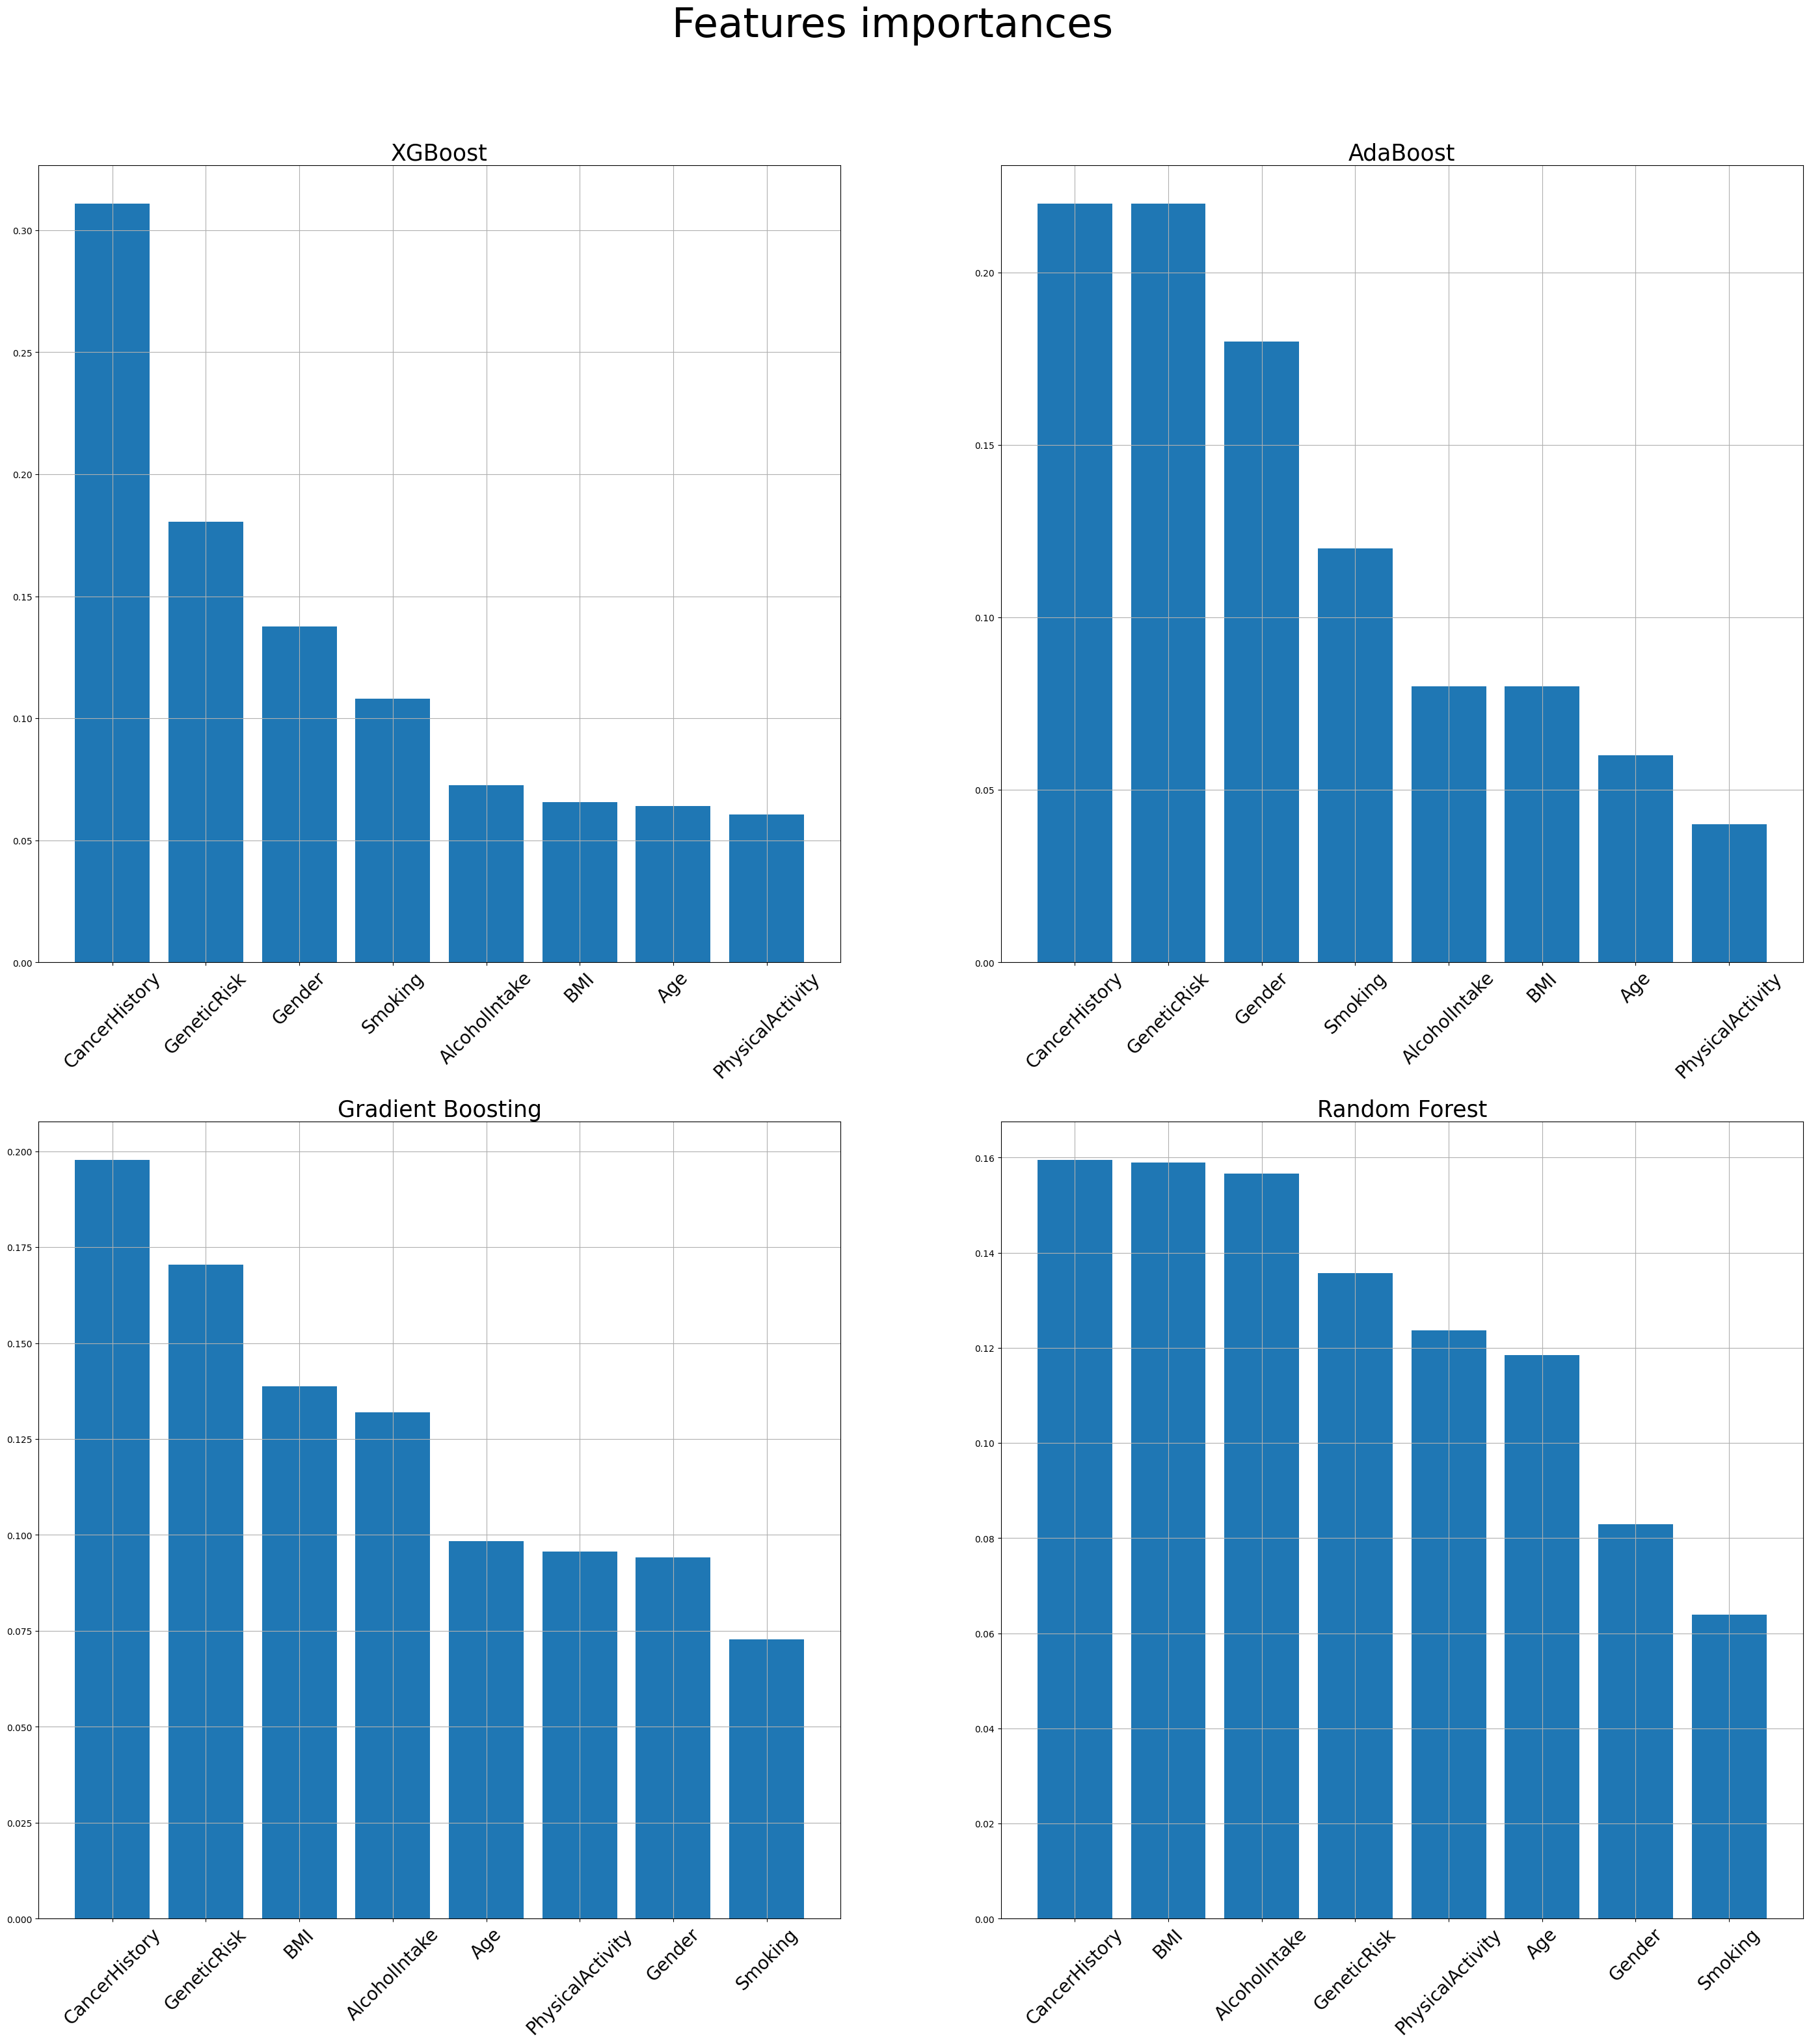

In [24]:
fig = plt.figure(figsize = (35,35))
fig.suptitle('Features importances',fontsize = 45,y = 0.95)

ax = fig.add_subplot(221)
plt.title("XGBoost",fontsize = 25) 
plt.grid()
plt.bar(range(X_train.shape[1]),importances_xgb[indices_xgb]) 
plt.xticks(range(X_train.shape[1]),names_xgb,rotation = 45,fontsize = 20) 

ax = fig.add_subplot(222)
plt.title("AdaBoost",fontsize = 25) 
plt.grid()
plt.bar(range(X_train.shape[1]),importances_ada[indices_ada]) 
plt.xticks(range(X_train.shape[1]),names_xgb,rotation = 45,fontsize = 20) 

ax = fig.add_subplot(223)
plt.title("Gradient Boosting",fontsize = 25) 
plt.grid()
plt.bar(range(X_train.shape[1]),importances_gb[indices_gb]) 
plt.xticks(range(X_train.shape[1]),names_gb,rotation = 45,fontsize = 20) 

ax = fig.add_subplot(224)
plt.title("Random Forest",fontsize = 25) 
plt.grid()
plt.bar(range(X_train.shape[1]),importances_rf[indices_rf]) 
plt.xticks(range(X_train.shape[1]),names_rf,rotation = 45,fontsize = 20) 

plt.show()
fig.savefig('importances.png',bbox_inches='tight')